In [37]:
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from skimage import io
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imwrite, imsave
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200
params = {'mathtext.default': 'regular','font.family':'Helvetica' }          
plt.rcParams.update(params)

In this workbook I aim to find the relationship between normalized cosine similarity and linear combination fitting by using synthetic spectra and cosine similarity

In [38]:
def cosine_similarity_3d(image,reference):
    """Take the cosine similarity of a hyperspectral image and a reference spectra of the same dimensions"""
    flat_image = (image.reshape((len(image),image.shape[1]*image.shape[2])).T)
    #Take the magnitude of each observation m for use in the cosine calculation
    norm = np.linalg.norm(flat_image, axis=1)
    #Calculate cosine similarity using CS = a.b/(||a||*||b||)
    cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))
    #reshape the cosine sum into a 2d image
    cosine_2d = np.nan_to_num(cosine.reshape((image.shape[1],image.shape[2])),posinf=0,neginf=0)
    return cosine_2d

def cosine_similarity_2d(line,reference):
    cosine = np.dot(line,reference)/(np.linalg.norm(line)*np.linalg.norm(reference))
    return cosine



#x*(oxide_ref-metal_ref)+metal_ref

In [39]:
#Read .csv files containing energy, intensity values for reference spectra
metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_metal_reference.csv",header=None,names=("energy","intensity"))
oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_oxide_reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
metal_ref_data = metal_ref_data.drop_duplicates(subset=["energy"])
metal_ref_data = metal_ref_data.sort_values(by=["energy"])
oxide_ref_data = oxide_ref_data.drop_duplicates(subset=["energy"])
oxide_ref_data = oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(metal_ref_data["energy"],metal_ref_data["intensity"])
oxide_ref_interp = CubicSpline(oxide_ref_data["energy"],oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
xrange = np.arange(570,584.2,0.2)
metal_ref = metal_ref_interp(xrange)
metal_ref = (metal_ref-min(metal_ref))/(max(metal_ref)-min(metal_ref))
oxide_ref = oxide_ref_interp(xrange)
oxide_ref = (oxide_ref-min(oxide_ref))/(max(oxide_ref)-min(oxide_ref))

def oxide_and_metal_refs(X, x_oxide,a):
    Y = a*(x_oxide*oxide_ref_interp(X)+(1-x_oxide)*metal_ref_interp(X))
    return Y

(101,)


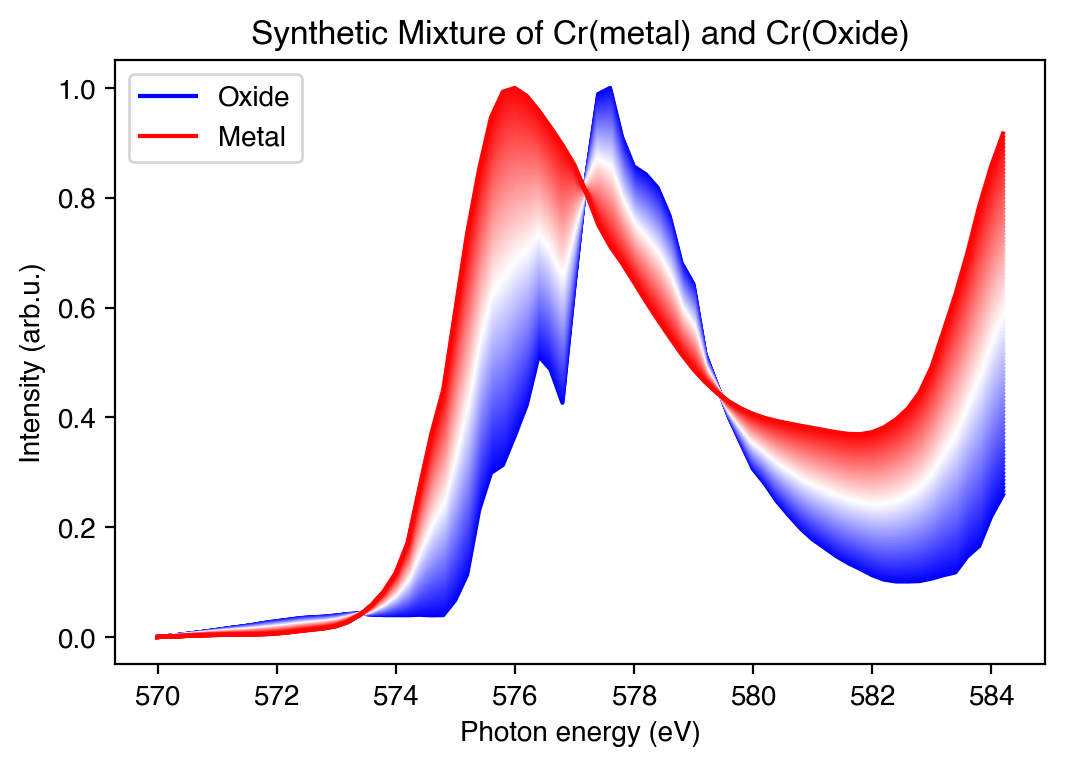

In [40]:
#Make a synthetic series
percentrange = np.arange(0,1.01,.01)
print(percentrange.shape)
synth = np.tile(percentrange,(len(metal_ref),1)).T
synth_metal = np.tile(metal_ref,(len(percentrange),1))*synth
synth_oxide = np.tile(oxide_ref,(len(percentrange),1))*(1-synth)
synth_spectra = synth_metal+synth_oxide

#Optionally add random noise
# noise = np.random.rand(synth_spectra.shape[0],synth_spectra.shape[1])*.05
# synth_spectra = synth_spectra+noise

#plot all the synthetic spectra
rb = cm.get_cmap("bwr")
for i,row in enumerate(synth_spectra):
    if i == 0:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Oxide')
    elif i == len(synth_spectra)-1:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Metal')
    else:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='_nolegend_')
    

plt.ylabel('Intensity (arb.u.)')
plt.xlabel('Photon energy (eV)')
plt.title('Synthetic Mixture of Cr(metal) and Cr(Oxide)')
plt.legend()
#synth_metal = synth_metal*percentrange

In [41]:
oxide_cs_synth = np.zeros(percentrange.shape)
oxide_cs_list = np.zeros(percentrange.shape)
metal_cs_list = np.zeros(percentrange.shape)
for i, row in enumerate(synth_spectra):
    metal_cs = cosine_similarity_2d(row,metal_ref)
    oxide_cs = cosine_similarity_2d(row,oxide_ref)
    oxide_cs_synth[i] = oxide_cs/(metal_cs+oxide_cs)
    oxide_cs_list[i] = oxide_cs
    metal_cs_list[i] = metal_cs

print(min(oxide_cs_synth),max(oxide_cs_synth))
# plt.plot(percentrange,oxide_cs_synth, c='b')
# plt.plot(percentrange,1-oxide_cs_synth,c='r')
# plt.legend(["Oxide","Metal"])
# plt.ylabel("Normalized Cosine Similarity")
# plt.xlabel("Metal Fraction")
# plt.title("Cosine Similarity of known synthetic spectra")

0.44756586572788126 0.5524341342721187


In [ ]:
# plt.plot(percentrange,metal_cs_list,c='r')
# plt.plot(percentrange,oxide_cs_list,c='b')
# plt.legend(["Oxide","Metal"])
# plt.ylabel("Normalized Cosine Similarity")
# plt.xlabel("Metal Fraction")
# plt.title("Cosine Similarity of known synthetic spectra")

Text(0.5, 1.0, 'Cosine Similarity of known synthetic spectra')

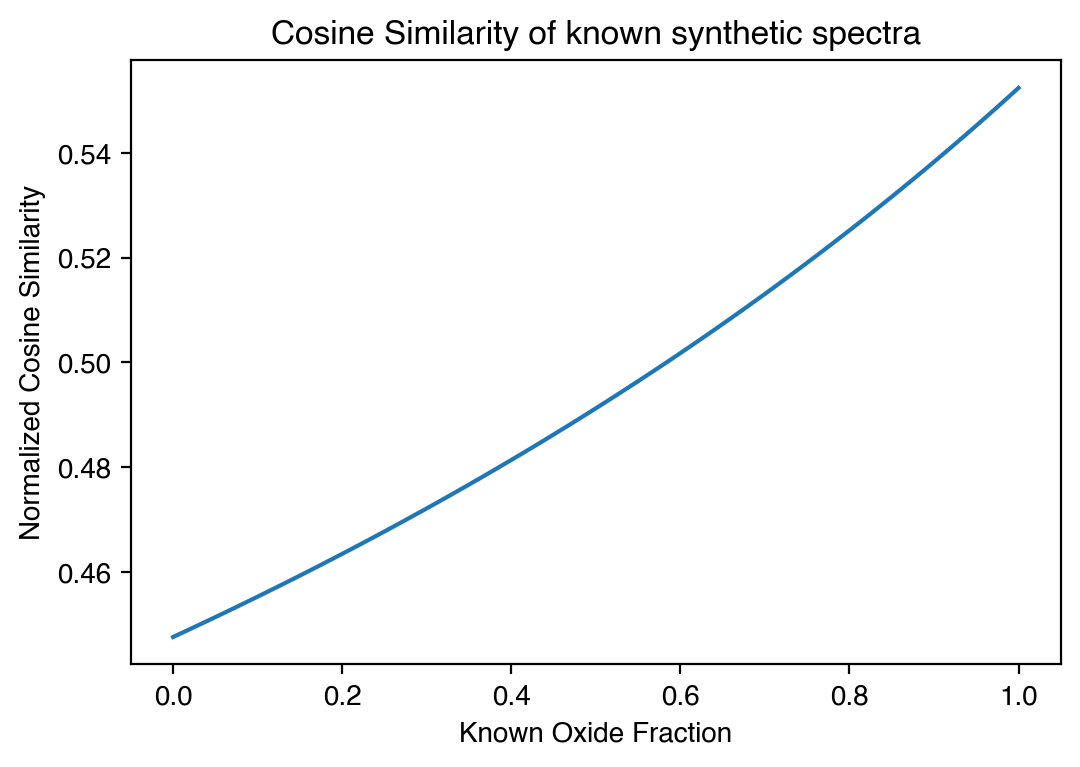

In [42]:
plt.plot(1-percentrange,oxide_cs_synth)
plt.ylabel("Normalized Cosine Similarity")
plt.xlabel("Known Oxide Fraction")
plt.title("Cosine Similarity of known synthetic spectra")

In [43]:
params = np.polyfit(oxide_cs_synth,1-percentrange,2)
print(params)

oxide_cs_to_percent = np.poly1d(params)

oxide_cs_to_percent(0.505)


[-30.69006309  40.12087749 -11.80374623]


0.63056356291691

In [44]:
# plt.plot(percentrange,metal_cs_list,c='r')
# plt.plot(percentrange,oxide_cs_list,c='b')
# plt.legend(["Oxide","Metal"])
# plt.ylabel("Normalized Cosine Similarity")
# plt.xlabel("Metal Fraction")
# plt.title("Cosine Similarity of known synthetic spectra")

Use Linear combination to find the concentrations of the spectra vs known concentration

0.9999999999999997
0.9999999999999994
0.9999999999999315
0.9999999999989894
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999992
0.999999999999996
0.9999999999999807
0.9999999999999157
0.9999999999996609
0.9999999999987172
0.9999999999953838
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999996
0.9999999999999969
0.9999999999999796
0.9999999999998622
0.999999999999047
0.9999999999931708
0.9999999999999999
0.9999999999999996
0.9999999999997919
0.9999999999637291
0.9999999999999889
0.9999999999880793
0.9999999999998476
0.9999999999908435
0.9661613667284755
0.8877947111425301
0.8149279425184194
0.7470040091859849
0.6835369175919637
0.6241009264677086
0.568325494324137
0.5158811695228145
0.46647795465649916
0.4198605040440903
0.3757980728181383
0.33408670249209665
0.2945430111385032
0.2570025735980123
0.2213167022567091
0.18735130495884983
0.15498495223730527
0.12410724274411555
0.09461786092142548
0.06642521102231744
0.03944555291055506
0.01360

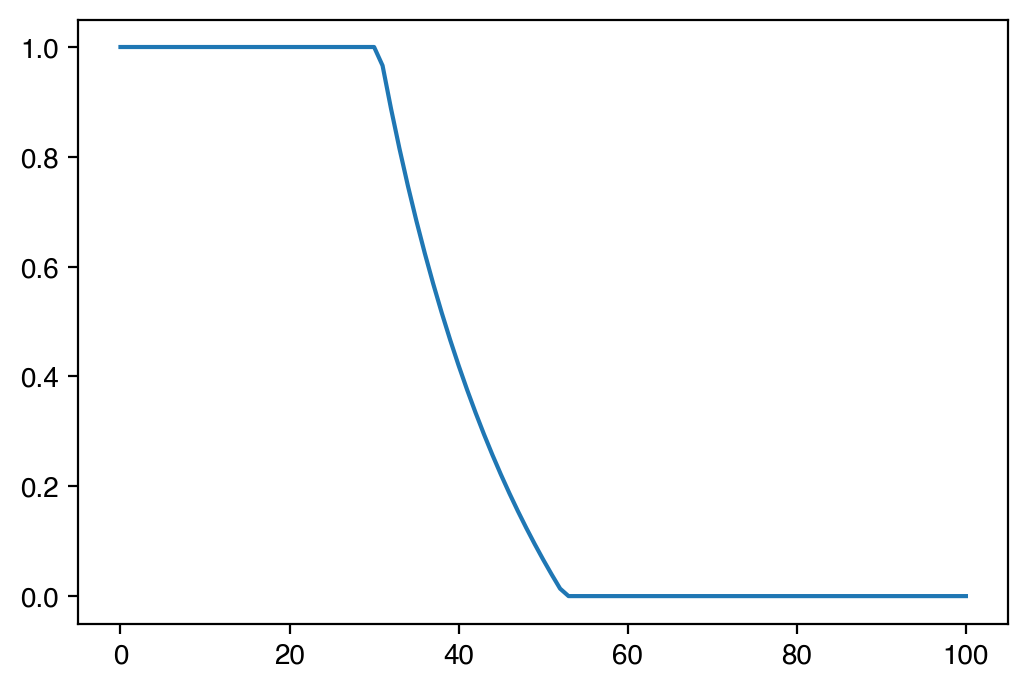

In [45]:
predicted_ox_frac = np.zeros(percentrange.shape)
def sinfunc(x,a, b):
    return np.sin(x)*a+b

for i, row in enumerate(synth_spectra):
    params, pcov = curve_fit(oxide_and_metal_refs, xrange, row, p0 = [0.5,1],bounds=(0,[1,1000]))
    predicted_ox_frac[i] = params[0]
    print(params[0])

plt.plot(predicted_ox_frac)

In [46]:
#Read in the hyperspectral image
cr5_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230715_Ni5Cr/XAS maps pre-oxidation/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_region2/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_region2.tif")
cr5_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1_region2/XAS_30um_2CA_1AN_570-584eV_0.2step_Cr2p_ox1_region2.tif")
cr5_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2_region2.tif")
mo_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif")
mo_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif")
mo_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p.tif")

